In [1]:
#carregar imatges a patient_data

import os
import pydicom
import numpy as np
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_modality_lut

def load_dicom_image_with_lut(dicom_path):
    try:
        # Read the DICOM file
        ds = pydicom.dcmread(dicom_path)
        
        # Extract the pixel data
        arr = ds.pixel_array
        
        # Apply the Modality LUT transformation
        hu = apply_modality_lut(arr, ds)
        
        return hu
    except Exception as e:
        # Handle any exceptions that may occur while processing the DICOM file
        print(f"Error loading DICOM image: {str(e)}")
        return None
    
# Define the root directory where your data is stored
data_root = "../FProject/Data/Train_Sets/CT"

# Iterate through patient folders
patient_data = {}  # Dictionary to store (patient_folder, image, mask) pairs

patient_folders = sorted(os.listdir(data_root))  # Sort patient folders
for patient_folder in os.listdir(data_root):
    if os.path.isdir(os.path.join(data_root, patient_folder)):
        dicom_folder = os.path.join(data_root, patient_folder, "DICOM_anon")
        ground_folder = os.path.join(data_root, patient_folder, "Ground")

        # Check if DICOM and Ground folders exist for the patient
        if os.path.exists(dicom_folder) and os.path.exists(ground_folder):
            dicom_files = sorted(os.listdir(dicom_folder))  # Sort DICOM files
            ground_files = sorted(os.listdir(ground_folder))  # Sort Ground files

            # Ensure both folders have the same number of files
            if len(dicom_files) == len(ground_files):
                patient_image_mask_pairs = []  # List to store (image, mask) pairs for this patient

                for dicom_file, ground_file in zip(dicom_files, ground_files):
                    dicom_path = os.path.join(dicom_folder, dicom_file)
                    ground_path = os.path.join(ground_folder, ground_file)

                    # Load DICOM files using pydicom and apply Modality LUT
                    dicom_array = load_dicom_image_with_lut(dicom_path)

                    # Load Ground images using PIL (or any other suitable library) and convert to NumPy array
                    ground = Image.open(ground_path)
                    ground_array = np.array(ground)

                    # Append the (image, mask) pair to the patient's list
                    patient_image_mask_pairs.append((dicom_array, ground_array))

                # Store the (image, mask) pairs for this patient in the dictionary
                patient_data[patient_folder] = patient_image_mask_pairs

# Now, patient_data is a dictionary where keys are patient identifiers, and values are lists of (DICOM, mask) pairs as NumPy arrays for each patient


In [2]:
#dividir en 3 diccionaris


# Assuming you have the patient_data dictionary containing patient IDs as keys and lists as values

# Extract the keys (patient IDs) from patient_data
patient_ids = list(patient_data.keys())

# Divide patient IDs into train, validation, and test sets
train_patients = patient_ids[:15]
val_patients = patient_ids[15:19]
test_patients = patient_ids[19:]

# Create dictionaries for train, validation, and test data
train_data = {patient_id: patient_data[patient_id] for patient_id in train_patients}
val_data = {patient_id: patient_data[patient_id] for patient_id in val_patients}
test_data = {patient_id: patient_data[patient_id] for patient_id in test_patients}


# Now you have train_data, val_data, and test_data dictionaries with the selected patients and their (DICOM, mask) pairs.

# For train_data
train_pairs = [(image, mask) for patient_data in train_data.values() for (image, mask) in patient_data]

# For val_data
val_pairs = [(image, mask) for patient_data in val_data.values() for (image, mask) in patient_data]

# For test_data
test_pairs = [(image, mask) for patient_data in test_data.values() for (image, mask) in patient_data]


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 512, 512, 8)  80          ['input_6[0][0]']                
                                                                                                  
 batch_normalization_90 (BatchN  (None, 512, 512, 8)  32         ['conv2d_95[0][0]']              
 ormalization)                                                                                    
                                                                                            

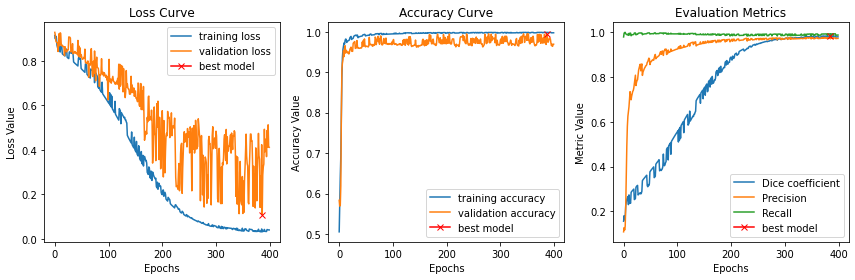

In [27]:
import numpy as np
import pydicom
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D,
    concatenate, Dropout, ReLU, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from Unet import conv_block, get_unet
from Functions import plotcurve, dice_coefficient, recall, precision, dice_loss


# Define your parameters
base = 8
img_h = 512
img_w = 512
img_ch = 1
batch_size = 8
learning_rate = 1e-5
dropout = True
dr = 0.2
batch_norm = True
num_epochs = 400
img_size= 512



# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='nearest')


def data_generator(data, batch_size):
    while True:
        batch_indices = np.random.choice(len(data), batch_size)
        batch_images = []
        batch_masks = []


        for idx in batch_indices:
            image, mask = data[idx]  # Assuming data is a list of tuples with pre-loaded images and masks as numpy arrays

            # Ensure image and mask are numpy arrays
            image = np.array(image, dtype=np.float32)
            mask = np.array(mask, dtype=np.float32)

            # Normalize image and mask
            image = normalize_image(image)
            mask = normalize_mask(mask)

            # Expand dimensions to make them multi-channel
            image = np.expand_dims(image, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            # Apply data augmentation to image and mask
            seed = np.random.randint(0, 1000)
            augmented_image = datagen.random_transform(image, seed=seed)
            augmented_mask = datagen.random_transform(mask, seed=seed)

            batch_images.append(augmented_image)
            batch_masks.append(augmented_mask)

        yield np.array(batch_images), np.array(batch_masks)


# Define the normalize_image and normalize_mask functions here
def normalize_image(image):
    # Implement your normalization logic here, scaling to [0, 1] based on the provided max_value
    return image / 1400

def normalize_mask(mask):
    # Ensure mask values are boolean (True/False)
    return mask.astype(bool)

# Create the U-Net model
modela = get_unet(img_h, img_w, img_ch, base, batch_norm, dropout, dr)

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true has the same data type as y_pred
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)
# Define the Dice loss function
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)


# Define precision metric
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# Define recall metric
def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    actual_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    return recall

def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / union
    return 1 - iou


# Compile the model
#modela.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['binary_accuracy',precision, recall,dice_coefficient])
#modela.compile(optimizer=Adam(learning_rate), loss=dice_loss, metrics=['binary_accuracy',dice_coefficient,precision,recall])
modela.compile(optimizer=Adam(learning_rate), loss=iou_loss, metrics=['binary_accuracy',precision, recall,dice_coefficient])


# Train the model
train_generator = data_generator(train_pairs, batch_size)
val_generator = data_generator(val_pairs, batch_size)

historya = modela.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_pairs) // batch_size,
    validation_steps=len(val_pairs) // batch_size)

plotcurve(historya,'binary')

In [28]:
modela.save("unet_model.h5")

from tensorflow import keras

#model = keras.models.load_model("unet_model.h5",custom_objects={'precision':precision,'recall':recall,'dice_coefficient':dice_coefficient, 'dice_loss':dice_loss})

model = keras.models.load_model("unet_model.h5",custom_objects={'precision':precision,'recall':recall,'dice_coefficient':dice_coefficient, 'iou_loss':iou_loss})


1/1 [==============================] - 0s 28ms/step


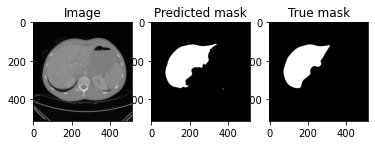

0.9570450495513803

In [45]:
#per una mask
import matplotlib.pyplot as plt
import numpy as np



def calculate_dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    dice_coefficient = (2.0 * intersection) / (mask1.sum() + mask2.sum())
    return dice_coefficient

# Iterate through the test_data list
image, mask = test_pairs[107]
image = normalize_image(image) # Make sure this function returns a NumPy array

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')


# Predict the mask
predicted_mask = model.predict(np.expand_dims(image, axis=0))   # Ensure predicted_mask is a 2D array
predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel

# Scale the predicted mask to the range [0, 255]
predicted_mask = (predicted_mask * 255).astype(np.uint8)
# Apply a threshold to make the mask binary

##########binary_mask = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)#

threshold = 100
predicted_mask_binary = np.where(predicted_mask > threshold, 255, 0).astype(np.uint8)
predicted_mask_boolean = (predicted_mask_binary > 0).astype(bool)

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_boolean, cmap='gray')
plt.title('Predicted mask')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('True mask')

plt.show()

calculate_dice_coefficient(mask, predicted_mask_boolean)


In [30]:
#Nomes pel primer pacient
import numpy as np
from tensorflow import keras

#model = keras.models.load_model("unet_model.h5",custom_objects={'precision':precision,'recall':recall,'dice_coefficient':dice_coefficient,'dice_loss':dice_loss})
model = keras.models.load_model("unet_model.h5",custom_objects={'precision':precision,'recall':recall,'dice_coefficient':dice_coefficient,'iou_loss':iou_loss})

def normalize_image(image):
    # Implement your normalization logic here, scaling to [0, 1] based on the provided max_value
    return image / 1400
def calculate_dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    dice_coefficient = (2.0 * intersection) / (mask1.sum() + mask2.sum())
    return dice_coefficient

# Selecting the first patient for debugging
first_patient_id, first_slices = next(iter(train_data.items()))

images = []
original_masks = []
predicted_masks = []

for image, mask in first_slices:
    # Predict the mask
    image = normalize_image(image)  # Make sure this function returns a NumPy array

    predicted_mask = model.predict(np.expand_dims(image, axis=0))

    # Ensure predicted_mask is a 2D array
    predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel

    # Scale the predicted mask to the range [0, 255]
    predicted_mask = (predicted_mask * 255).astype(np.uint8)

    # Apply a threshold to make the mask binary
    threshold = 100  # Adjust this threshold as needed
    predicted_mask_binary = np.where(predicted_mask > threshold, 255, 0).astype(np.uint8)
    predicted_mask_boolean = (predicted_mask_binary > 0).astype(bool)

    images.append(image)
    original_masks.append(mask)
    predicted_masks.append(predicted_mask_boolean)

# Display variables for debugging
print(f"Original Masks: {original_masks}")
print(f"Predicted Masks: {predicted_masks}")

original_masks_array = np.array(original_masks)
predicted_masks_array = np.array(predicted_masks)

# Compute the Dice score
dice = calculate_dice_coefficient(original_masks_array, predicted_masks_array)
print(f"Dice Score for Patient ID {first_patient_id}: {dice}")


1/1 [==============================] - 0s 19ms/step
Original Masks: [array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, Fal

In [31]:
#per tots els pacients dins train_data
import numpy as np

def calculate_dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    dice_coefficient = (2.0 * intersection) / (mask1.sum() + mask2.sum())
    return dice_coefficient

dice_scores = []

for patient_id, slices in train_data.items():
    images = []
    original_masks = []
    predicted_masks = []

    for image, mask in slices:
        # Predict the mask
        image = normalize_image(image) # Make sure this function returns a NumPy array

        predicted_mask = model.predict(np.expand_dims(image, axis=0))

        # Ensure predicted_mask is a 2D array
        predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel

        # Scale the predicted mask to the range [0, 255]
        predicted_mask = (predicted_mask * 255).astype(np.uint8)

        # Apply a threshold to make the mask binary
        threshold = 100  # Adjust this threshold as needed
        predicted_mask_binary = np.where(predicted_mask > threshold, 255, 0).astype(np.uint8)
        predicted_mask_boolean = (predicted_mask_binary > 0).astype(bool)

        original_masks.append(mask)
        predicted_masks.append(predicted_mask_boolean)

    original_masks_array = np.array(original_masks)
    predicted_masks_array = np.array(predicted_masks)

    # Compute the Dice score
    dice = calculate_dice_coefficient(original_masks_array, predicted_masks_array)
    dice_scores.append((patient_id, dice))

# Display Dice scores for each patient
for patient_id, dice_score in dice_scores:
    print(f"Patient ID: {patient_id}, Dice Score: {dice_score}")


1/1 [==============================] - 0s 19ms/step
Patient ID: 30, Dice Score: 0.9624792572119609
Patient ID: 28, Dice Score: 0.9593398341611101
Patient ID: 24, Dice Score: 0.9498160400907476
Patient ID: 27, Dice Score: 0.9640767267291007
Patient ID: 8, Dice Score: 0.9522753306821129
Patient ID: 22, Dice Score: 0.9798398603293098
Patient ID: 23, Dice Score: 0.9645984778452048
Patient ID: 21, Dice Score: 0.945144221217558
Patient ID: 10, Dice Score: 0.9766896764826382
Patient ID: 6, Dice Score: 0.9598886341146675
Patient ID: 2, Dice Score: 0.9686989413958864
Patient ID: 14, Dice Score: 0.9504854263825119
Patient ID: 19, Dice Score: 0.9646002297847247
Patient ID: 18, Dice Score: 0.972357501439933
Patient ID: 1, Dice Score: 0.9738192285722802


In [32]:
#per tots els pacients dins val_data
import numpy as np

def calculate_dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    dice_coefficient = (2.0 * intersection) / (mask1.sum() + mask2.sum())
    return dice_coefficient

dice_scores = []

for patient_id, slices in val_data.items():
    images = []
    original_masks = []
    predicted_masks = []

    for image, mask in slices:
        # Predict the mask
        image = normalize_image(image) # Make sure this function returns a NumPy array

        predicted_mask = model.predict(np.expand_dims(image, axis=0))

        # Ensure predicted_mask is a 2D array
        predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel

        # Scale the predicted mask to the range [0, 255]
        predicted_mask = (predicted_mask * 255).astype(np.uint8)

        # Apply a threshold to make the mask binary
        threshold = 100  # Adjust this threshold as needed
        predicted_mask_binary = np.where(predicted_mask > threshold, 255, 0).astype(np.uint8)
        predicted_mask_boolean = (predicted_mask_binary > 0).astype(bool)

        original_masks.append(mask)
        predicted_masks.append(predicted_mask_boolean)

    original_masks_array = np.array(original_masks)
    predicted_masks_array = np.array(predicted_masks)

    # Compute the Dice score
    dice = calculate_dice_coefficient(original_masks_array, predicted_masks_array)
    dice_scores.append((patient_id, dice))

# Display Dice scores for each patient
for patient_id, dice_score in dice_scores:
    print(f"Patient ID: {patient_id}, Dice Score: {dice_score}")


1/1 [==============================] - 0s 19ms/step
Patient ID: 16, Dice Score: 0.8670299418501277
Patient ID: 25, Dice Score: 0.14542361084258149
Patient ID: 5, Dice Score: 0.9391806634056494
Patient ID: 26, Dice Score: 0.9425593575710082


In [33]:
#per tots els pacients dins test_data
import numpy as np

def calculate_dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    dice_coefficient = (2.0 * intersection) / (mask1.sum() + mask2.sum())
    return dice_coefficient

dice_scores = []

for patient_id, slices in test_data.items():
    images = []
    original_masks = []
    predicted_masks = []

    for image, mask in slices:
        # Predict the mask
        image = normalize_image(image) # Make sure this function returns a NumPy array

        predicted_mask = model.predict(np.expand_dims(image, axis=0))

        # Ensure predicted_mask is a 2D array
        predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel

        # Scale the predicted mask to the range [0, 255]
        predicted_mask = (predicted_mask * 255).astype(np.uint8)

        # Apply a threshold to make the mask binary
        threshold = 100  # Adjust this threshold as needed
        predicted_mask_binary = np.where(predicted_mask > threshold, 255, 0).astype(np.uint8)
        predicted_mask_boolean = (predicted_mask_binary > 0).astype(bool)

        original_masks.append(mask)
        predicted_masks.append(predicted_mask_boolean)

    original_masks_array = np.array(original_masks)
    predicted_masks_array = np.array(predicted_masks)

    # Compute the Dice score
    dice = calculate_dice_coefficient(original_masks_array, predicted_masks_array)
    dice_scores.append((patient_id, dice))

# Display Dice scores for each patient
for patient_id, dice_score in dice_scores:
    print(f"Patient ID: {patient_id}, Dice Score: {dice_score}")


1/1 [==============================] - 0s 18ms/step
Patient ID: 29, Dice Score: 0.9440534279678809


In [46]:
#per fer carpetes

import cv2 

# Initialize lists for images and masks
test_images = []
test_masks = []

# Iterate through the test_data list
for patient_id, data in test_data.items():
    for image, mask in data:
        test_images.append(image)
        test_masks.append(mask)


# Now, test_images contains only the images, and test_masks contains the corresponding masks

import os

predicted_masks = []  # To store the predicted masks

    
output_dir = "../FProject/Data/Predicted_masks"  # Directory to save the predicted masks
os.makedirs(output_dir, exist_ok=True)

for i, image in enumerate(test_images):
    # Preprocess the image
    image = normalize_image(image)  # Make sure this function returns a NumPy array

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(image, axis=0))

    # Ensure predicted_mask is a 2D array
    predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel

    # Scale the predicted mask to the range [0, 255]
    predicted_mask = (predicted_mask * 255).astype(np.uint8)

    # Apply a threshold to make the mask binary
    threshold = 100  # Adjust this threshold as needed
    predicted_mask_binary = np.where(predicted_mask > threshold, 255, 0).astype(np.uint8)
    predicted_mask_boolean = (predicted_mask_binary > 0).astype(bool)

 # Convert boolean mask to uint8 (0 and 255)
    predicted_mask_uint8 = predicted_mask_boolean.astype(np.uint8) * 255

    # Convert to PIL Image
    predicted_mask_image = Image.fromarray(predicted_mask_uint8, mode="L")

    # Save the predicted mask
    predicted_mask_path = os.path.join(output_dir, f"predicted_mask_{i}.png")
    predicted_mask_image.save(predicted_mask_path)

    # Convert the true mask to a NumPy array (boolean to uint8)
    true_mask = test_masks[i].astype(np.uint8) * 255  # Convert boolean to uint8 and scale to [0, 255]

    # Convert to PIL Image
    true_mask_image = Image.fromarray(true_mask, mode="L")

    # Save the corresponding true mask
    true_mask_path = os.path.join(output_dir, f"true_mask_{i}.png")
    true_mask_image.save(true_mask_path)


1/1 [==============================] - 0s 20ms/step
